In [35]:
%pip install -q scikit-learn==1.5.2
%pip install -q statsforecast
%pip install -q gdown
%pip install -q tsururu==1.0.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [60]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox

warnings.filterwarnings("ignore")

In [37]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

# Загрузка и первичный анализ данных

Иногда данные, которые содержат временные ряды, могут быть представлены в tsf формате. Это такая структура данных, которая позволяет хранить метаинформацию о временных рядах, а также пары "первая дата — все значения временного ряда".

Но все же привычнее работать с форматом pandas DataFrame. Поэтому мы будем использовать его.


In [38]:
def convert_tsf_to_dataframe(
    full_file_path_and_name: str,
    replace_missing_vals_with: Any = "NaN",
    value_column_name: str = "series_value",
) -> tuple[pd.DataFrame, str, int, str, str]:
    """
    Конвертирует файл формата TSF в pandas DataFrame.

    Args:
        full_file_path_and_name: Путь к файлу формата TSF.
        replace_missing_vals_with: Значение для замены пропусков.
        value_column_name: Имя столбца для значений временных рядов.

    Returns:
        DataFrame с данными временных рядов.
        Частота данных.
        Прогнозируемый горизонт.
        Содержат ли данные пропуски.
        Равны ли длины временных рядов.

    """
    col_names = []
    col_types = []
    all_data = {}
    all_series = []
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    data_started = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            if line.startswith("@"):
                if line.startswith("@data"):
                    data_started = True
                    # Инициализируем словарь для данных атрибутов
                    for col in col_names:
                        all_data[col] = []
                else:
                    parts = line.split(" ")
                    if line.startswith("@attribute"):
                        col_names.append(parts[1])
                        col_types.append(parts[2])
                    elif line.startswith("@frequency"):
                        frequency = parts[1]
                    elif line.startswith("@horizon"):
                        forecast_horizon = int(parts[1])
                    elif line.startswith("@missing"):
                        contain_missing_values = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
                    elif line.startswith("@equallength"):
                        contain_equal_length = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
            elif not line.startswith("#") and data_started:
                parts = line.split(":")
                # Последняя часть содержит значения ряда
                series_vals = parts[-1].split(",")
                numeric_series = [
                    replace_missing_vals_with if val == "?" else float(val) for val in series_vals
                ]
                all_series.append(pd.Series(numeric_series).array)
                # Преобразуем и сохраняем значения атрибутов
                for i in range(len(col_names)):
                    if col_types[i] == "numeric":
                        all_data[col_names[i]].append(int(parts[i]))
                    elif col_types[i] == "string":
                        all_data[col_names[i]].append(parts[i])
                    elif col_types[i] == "date":
                        all_data[col_names[i]].append(
                            datetime.strptime(parts[i], "%Y-%m-%d %H-%M-%S")
                        )

    all_data[value_column_name] = all_series
    loaded_data = pd.DataFrame(all_data)
    return loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length


def date_to_daterange(x: pd.Series, freq: str) -> pd.Series:
    """
    Преобразует временные метки в диапазон дат.

    Args:
        x: Временные метки.
        freq: Частота.

    Returns:
        pd.Series с диапазоном дат.

    """
    return pd.Series(pd.date_range(start=x.iloc[0], periods=len(x), freq=freq))


def convert_tsf_to_multivariate_or_standard_format(
    tsf_data_path: str,
    target_column: str = "series_value",
    date_from_column: str = "start_timestamp",
    id_column: str = "series_name",
    # one from ["multivariate", "standard"]
    format: str = "multivariate",
) -> pd.DataFrame:
    """
    Преобразует данные формата TSF в формат pandas DataFrame:
        если format == "standard" -> датафрейм с колонками "id", "date" и "value"
        если format == "multivariate" -> pivot таблица c date в качестве индекса,
            id в качестве колонок и значениями из value_column_name

    Args:
        tsf_data_path: Путь к файлу формата TSF.
        target_column: Имя столбца с целевой переменной.
        date_from_column: Имя столбца с переменной дат.
        id_column: Имя столбца с идентификаторами временных рядов.
        format: Формат данных ("multivariate" или "standard").

    Returns:
        pd.DataFrame с данными в формате "id", "date" и "value".

    """
    FREQ_MAP = {
        "monthly": "MS",
        "10_minutes": "10min",
        "half_hourly": "30min",
        "minutely": "1min",
        "daily": "D",
        "weekly": "7D",
        "yearly": "YS",
        "quarterly": "QS",
        "hourly": "H",
    }

    tsf_df, freq = convert_tsf_to_dataframe(tsf_data_path)[:2]

    # Преобразуем списки в {target_column} в "длинный столбец" со значениями
    tsf_df = tsf_df.explode(target_column)
    # Заменим повторяющиеся значения даты в {date_column} на date_range
    tsf_df["date"] = (
        tsf_df.groupby(id_column, sort=False)[date_from_column]
        .apply(lambda x: date_to_daterange(x, FREQ_MAP[freq]))
        .values
    )
    tsf_df = tsf_df.drop(columns=date_from_column)
    # Переименуем колонки
    tsf_df = tsf_df.rename(columns={id_column: "id", target_column: "value"}).reset_index(
        drop=True
    )
    # Приведем {id_column} к численным значениям
    ids2num = dict(zip(tsf_df["id"].unique(), np.arange(tsf_df["id"].nunique())))
    tsf_df["id"] = tsf_df["id"].map(ids2num)

    if format == "standard":
        return tsf_df
    return pd.pivot_table(tsf_df, values="value", index="date", columns="id")

__Посмотрим на данные.__

In [39]:
# Скачаем данные с Google Drive
!gdown 1Y6tIlfxYgN7Jxi3_pI6nHwgDmhiBSDIa

Downloading...
From: https://drive.google.com/uc?id=1Y6tIlfxYgN7Jxi3_pI6nHwgDmhiBSDIa
To: /kaggle/working/tourism_monthly_dataset.tsf
100%|█████████████████████████████████████████| 516k/516k [00:00<00:00, 100MB/s]


Работать мы будем  с датасетом Tourism, который содержит данные о количестве туристов в разных странах — https://zenodo.org/records/4656096.

In [40]:
df = convert_tsf_to_multivariate_or_standard_format('tourism_monthly_dataset.tsf', format="standard")
df.head()

,id,value,date
0,0,1149.87,1979-01-01
1,0,1053.8002,1979-02-01
2,0,1388.8798,1979-03-01
3,0,1783.3702,1979-04-01
4,0,1921.0252,1979-05-01


In [41]:
fig = go.Figure()
seed_everything()
random_ids = np.random.choice(df["id"].unique(), 10, replace=False)

for i in random_ids:
    fig.add_trace(
        go.Scatter(x=df[df["id"] == i]["date"], y=df[df["id"] == i]["value"], name=str(i))
    )
fig.update_layout(title="Tourism Monthly Dataset", xaxis_title="Date", yaxis_title="Value")
fig.show()

__`Вопросы:`__

__Что можно сказать про эти временные ряды?__
- Стационарны ли они?
- Различаются ли ряды между собой?

__Выберите какой-то один ряд и посмотрите на него более подробно.__
- Есть ли в нем тренд (линейный, экспоненциальный или какой-то другой)?
- Есть ли в нем сезонность (аддитивная или мультипликативная)?
- Есть ли в нем точки смены режима (точки, в которых сильно меняется поведение ряда)?
- Есть ли в нем выбросы?

Если ответы на вопросы затруднительны, то вспомним какие компоненты ряд может иметь и вспомним определение стационарности ряда.

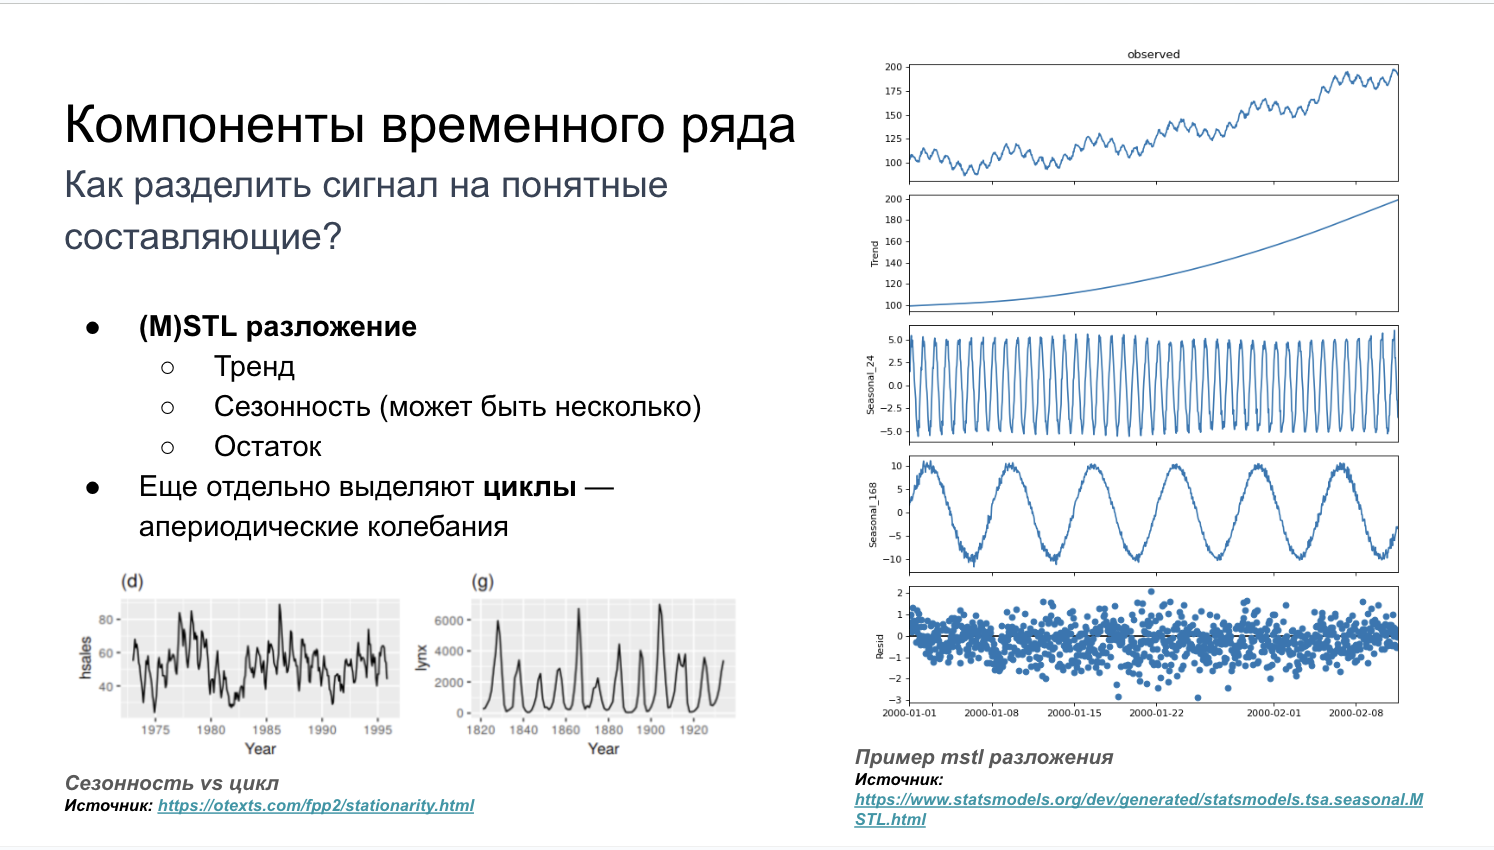

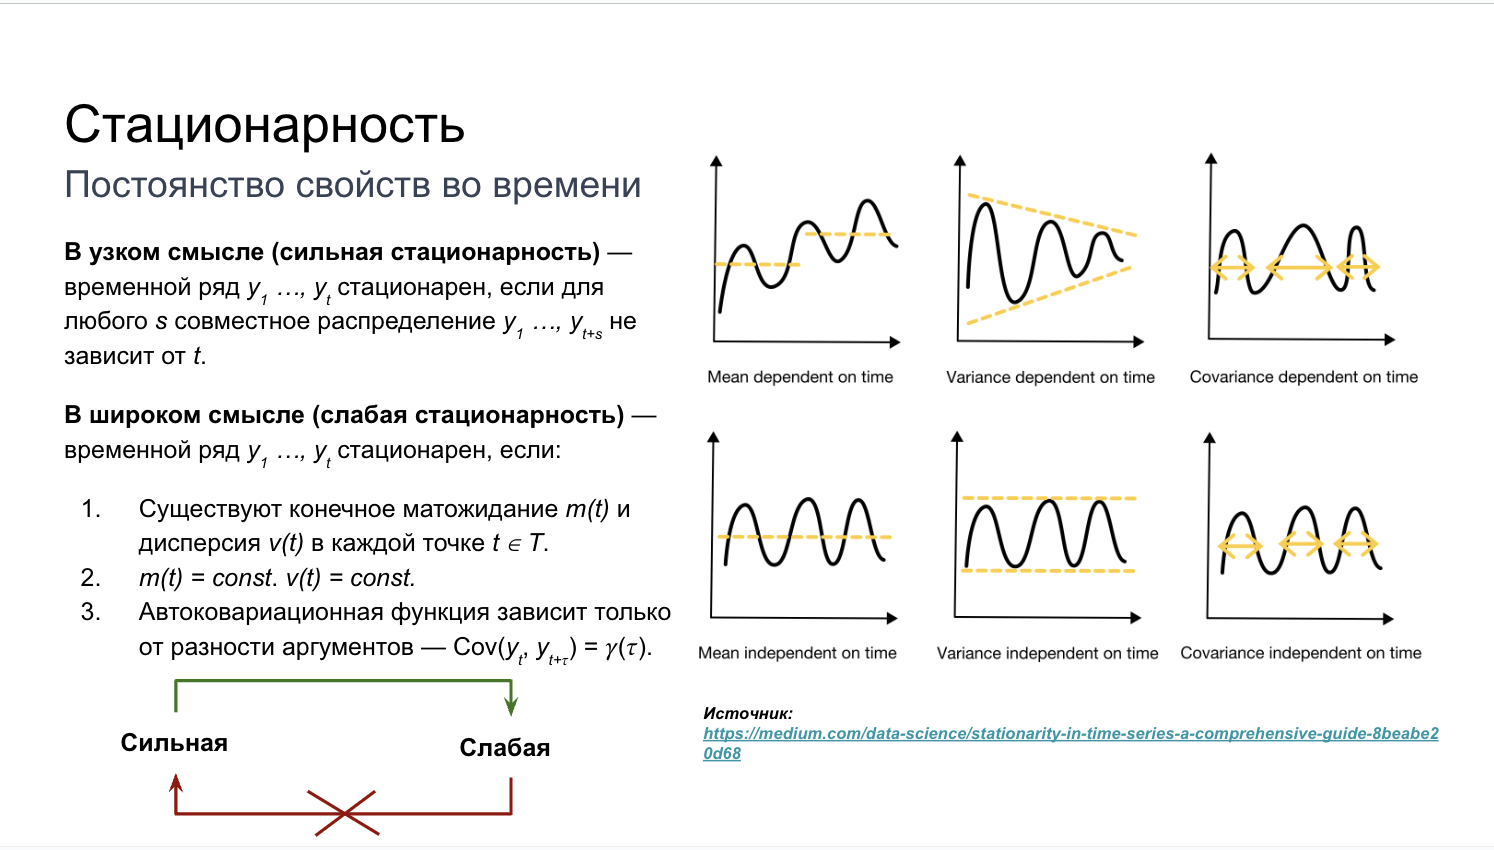

## Полный анализ одного временного ряда

In [42]:
HORIZON = 36

random_series = 33  # Вот так захотелось :)
random_series = df[df["id"] == random_series]

# Разделим данные на обучающую и тестовую выборки
train_size = len(random_series) - HORIZON
train_split_date = np.sort(random_series["date"])[train_size]

train_data = random_series[random_series["date"] < train_split_date]
test_data = random_series[random_series["date"] >= train_split_date]

__`Вопрос:`__ __Почему при анализе временных рядов мы не можем просто использовать рандомное разбиение на train и test?__

In [43]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=train_data["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=test_data["value"], name="Test", line=dict(color="red"))
)
fig.update_layout(
    title="Train/Test Split", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

__Очевидно, что ряд нестационарный. Посмотрим, что на это скажут статистические тесты.__

## Тесты на стационарность

Рассмотрим два наиболее популярных теста на стационарность:
- Тест Дики-Фуллера (Augmented Dickey-Fuller test) — https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
- KPSS-тест (Kwiatkowski-Phillips-Schmidt-Shin test) — https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html

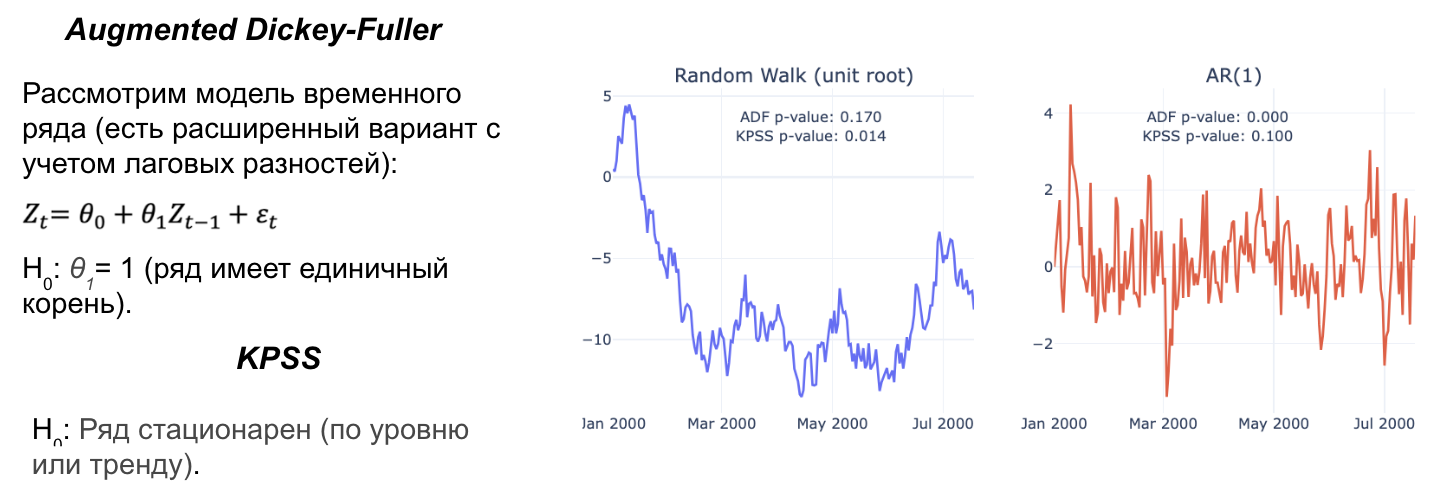

In [44]:
# KPSS test
# H0: временной ряд стационарен
# H1: временной ряд не стационарен
statistic, p_value, lags, critical_values = kpss(train_data["value"])
print(f"KPSS p-value: {p_value}")

# ADF test
# H0: unit root (не стационарен)
# H1: no unit root (стационарен)
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(train_data["value"])
print(f"ADF p-value: {p_value}")

KPSS p-value: 0.01
ADF p-value: 0.9515404931313133


__`Вопрос:`__ __Как интерпретировать результаты этих тестов?__

## STL разложение

Попробуем выделить явно тренд и сезонность при помощи STL разложения — https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html.

__`Вопрос:`__ __STL разложение требует указания периода. Как его выбрать, исходя из данных?__

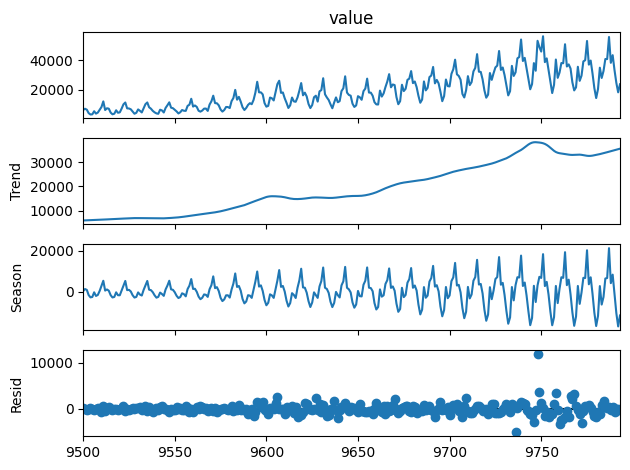

In [45]:
PERIOD = 12

res = STL(train_data["value"], period=12).fit()
res.plot()
plt.show()

__`Вопросы:`__

- __Как интерпретировать результаты разложения?__
- __Получим ли мы стационарный ряд, если вычтем из него тренд и сезонность?__

__`Упражнение:`__

__Проведите тесты ADF и KPSS на остаточной части временного ряда. Как изменились результаты?__

In [46]:
# Решение
residuals = res.resid
statistic, p_value, lags, critical_values = kpss(residuals)
print(f"KPSS p-value: {p_value}")
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(residuals)
print(f"ADF p-value: {p_value}")

KPSS p-value: 0.1
ADF p-value: 3.1622534379762866e-10


STL-разложение можно использовать для того, чтобы затем строит пайплайны моделей на основое получившихся компонент.

Так, можно тренд и сезонность предсказать простыми моделями, а затем результаты сложить. Остатки можно приблизить ARMA-моделью.

Попробуем сделать первую часть, а именно: построим прогноз тренда методом простого экспоненциального сглаживания, сезонность – наивным повторением последнего цикла, а итоговый прогноз будем считать как сумму тренда и сезонности.

In [51]:
HORIZON = 36

# Генерируем индекс для прогноза
freq = pd.infer_freq(train_data["date"])
start = train_data["date"].values[-1] + pd.tseries.frequencies.to_offset(freq)
forecast_index = pd.date_range(start=start, periods=HORIZON, freq=freq)

# Прогноз тренда методом простого экспоненциального сглаживания
trend = res.trend.dropna()
model_trend = SimpleExpSmoothing(trend).fit()
trend_fc = model_trend.forecast(HORIZON)
trend_fc.index = forecast_index

# Наивный сезонный прогноз
seasonal = res.seasonal
last_season = seasonal.iloc[-PERIOD:]
seasonal_vals = np.tile(last_season.values, int(np.ceil(HORIZON / PERIOD)))[:HORIZON]
seasonal_fc = pd.Series(seasonal_vals, index=forecast_index)

# Суммируем компоненты и собираем итоговый прогноз
forecast_df = pd.DataFrame({
    'trend':      trend_fc,
    'seasonal':   seasonal_fc
})
forecast_df['forecast'] = forecast_df['trend'] + forecast_df['seasonal']

In [53]:
forecast_df.head()

,trend,seasonal,forecast
2004-07-01,35599.247874,2723.469119,38322.716992
2004-08-01,35599.247874,-6230.990132,29368.257742
2004-09-01,35599.247874,-2551.680234,33047.567640
2004-10-01,35599.247874,6403.488361,42002.736235
2004-11-01,35599.247874,6642.241350,42241.489224


In [54]:
predictions = pd.DataFrame({"date": forecast_df.index, "value": forecast_df["forecast"]})
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=train_data["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=test_data["value"], name="Test", line=dict(color="red"))
)
fig.add_trace(
    go.Scatter(
        x=predictions["date"], y=predictions["value"], name="Predictions", line=dict(color="green")
    )
)
fig.update_layout(
    title="Train/Test Split with Predictions", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

mae = mean_absolute_error(test_data["value"], predictions["value"])
print(f"MAE: {mae}")

MAE: 2768.7913277886055


## ACF, PACF, SARIMA

Теперь подойдем к ряду с другой стороны — через графики автокорреляций. Построим на их основе SARIMA модель.

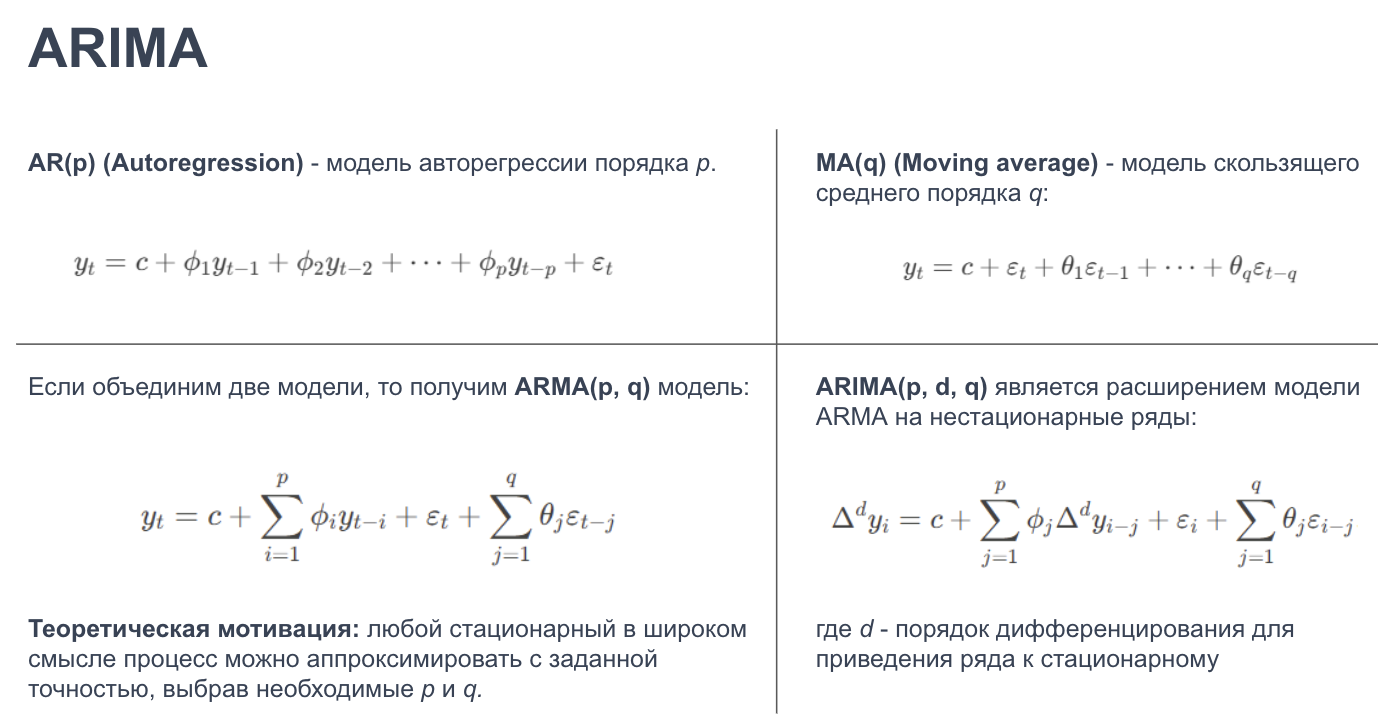

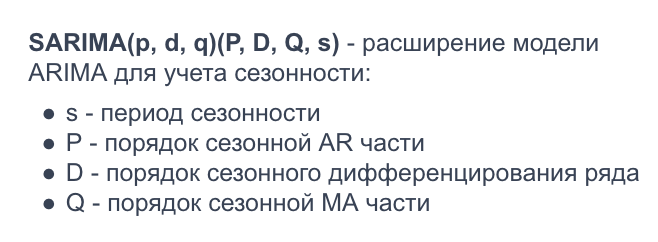

Ручной подбор гиперпараметров для подобных моделей — ручной и итеративный процесс, который плохо масштабируется на ситуации, когда нужно прогнозировать сотни и даже тысячи временных рядов одновременно. Давайте один раз попробуем это сделать, чтобы понять, насколько это неприятная процедура.

Правила построения SARIMA модели хорошо описаны в этой статье: https://people.duke.edu/~rnau/arimrule.html

Так как сезонность мультипликативная, то попробуем логарифмировать ряд.

In [55]:
log_train_data = np.log(train_data["value"].astype("float"))
log_test_data = np.log(test_data["value"].astype("float"))

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=log_train_data, name="Log Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=log_test_data, name="Log Test", line=dict(color="red"))
)
fig.update_layout(
    title="Log Train/Test Split", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

Построим графики ACF и PACF.

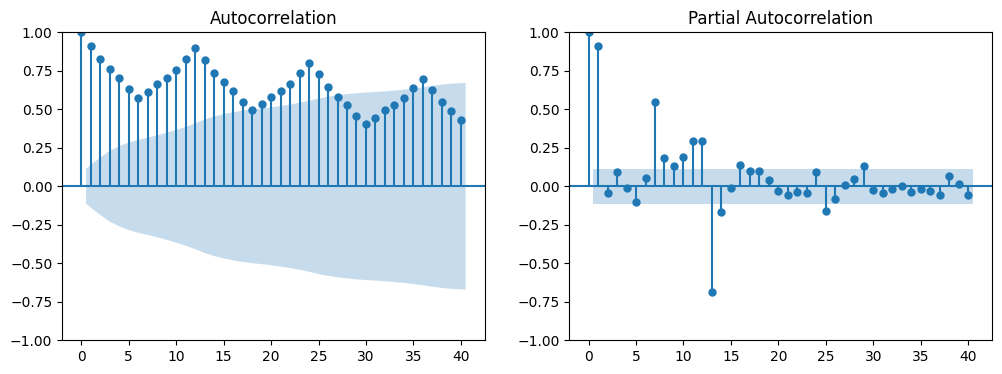

In [56]:
# ACF и PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(log_train_data, lags=40, ax=ax[0])
plot_pacf(log_train_data, lags=40, ax=ax[1])
plt.show()

- По первому правилу, если ряд имеет положительные автокорреляции до большого числа лагов, то, вероятно, требуется более высокий порядок дифференцирования.
- По двенадцатому правилу, если ряд имеет ярко выраженный и устойчивый сезонный паттерн, то необходимо использовать порядок сезонного дифференцирования.

Никогда не применяйте более одного порядка сезонного дифференцирования или более двух порядков общего дифференцирования (сезонного + несезонного).

Проведем сезонное и "обычное" дифференцирование и снова посмотрим на графики ACF и PACF.

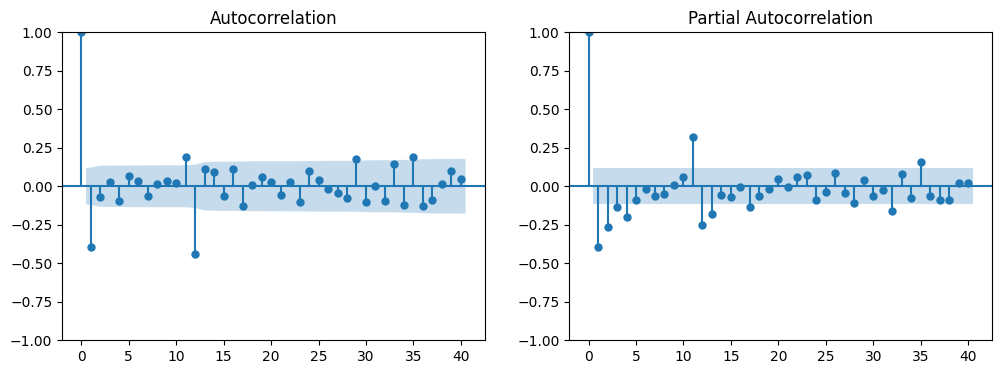

In [57]:
# ACF и PACF после сезонного и обычного дифференцирования
diff_seas_series = log_train_data.diff(PERIOD).dropna()
diff__diff_series = diff_seas_series.diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(diff__diff_series, lags=40, ax=ax[0])
plot_pacf(diff__diff_series, lags=40, ax=ax[1])
plt.show()

- По седьмому правилу, лаг, после которого ACF обрывается, указывает на требуемое количество MA членов.
- По тренадцатому правилу, если автокорреляция дифференцированного ряда отрицательна на лаге s, то надо добавить SMA член в модель.

__Итого наш первый кандидат: SARIMA(0, 1, 1)(0, 1, 1, 12)__

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  294
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 264.783
Date:                            Thu, 17 Apr 2025   AIC                           -523.565
Time:                                    06:15:21   BIC                           -512.804
Sample:                                         0   HQIC                          -519.243
                                            - 294                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6336      0.048    -13.246      0.000      -0.727      -0.540
ma.S.L12      -0.6616      0.044   

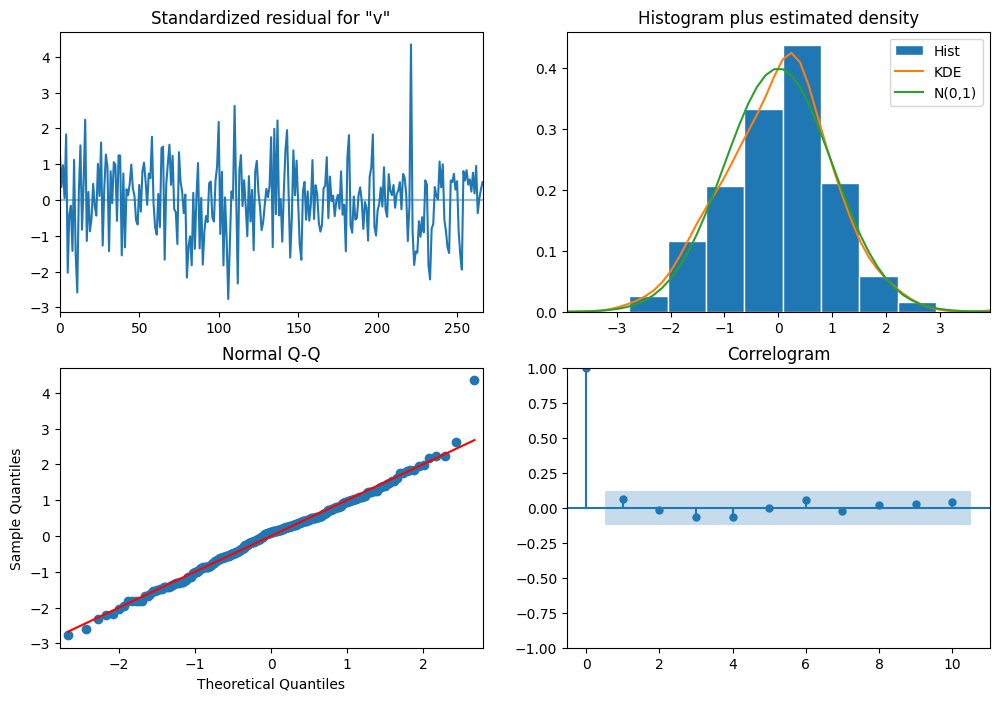

In [58]:
# SARIMA(0, 1, 1)(0, 1, 1, 12) на log ряде
model = SARIMAX(
    log_train_data,
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, PERIOD),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [59]:
predicted_mean = model_fit.get_forecast(steps=HORIZON).predicted_mean.reset_index(drop=True)
predicted_mean = np.exp(predicted_mean)

predictions = pd.DataFrame({"date": test_data["date"], "value": predicted_mean.values})
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=train_data["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=test_data["value"], name="Test", line=dict(color="red"))
)
fig.add_trace(
    go.Scatter(
        x=predictions["date"], y=predictions["value"], name="Predictions", line=dict(color="green")
    )
)
fig.update_layout(
    title="Train/Test Split with Predictions", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

mae = mean_absolute_error(test_data["value"], predictions["value"])
print(f"MAE: {mae}")

MAE: 2200.7302645068035


Обычно говорят, что остатки модели (любой, не только SARIMA) должны быть стационарными и не иметь автокорреляций. Тогда считается, что мы сделали все, что могли, и осталась только компонента шума.

Информацию об остатках можно получить из `model_fit.plot_diagnostics()`, а также из дополнительных тестов.

Давайте проверим, что остатки являются стационарными и представляют собой «белый шум» без автокорреляции с помощью уже знакомых тестов ADF/KPSS и теста на автокорреляцию Льюнг–Бокса — https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html

In [63]:
# H0: остатки стационарны
residuals = model_fit.resid
statistic, p_value, lags, critical_values = kpss(residuals)
print(f"KPSS p-value: {p_value}")

# H0: остатки не стационарны
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(residuals)
print(f"ADF p-value: {p_value}")

# H0: автокорреляция отсутствует
lb_test = acorr_ljungbox(residuals, lags=[10, 12], return_df=True)
print(lb_test)

KPSS p-value: 0.1
ADF p-value: 0.0
      lb_stat     lb_pvalue
10   2.426555  9.919033e-01
12  70.834595  2.234975e-10


Для 10-го лага H0 не отвергаем, а вот для 12-го лага H0 отвергается — возможно, мы не до конца учли сезонность и остатки все еще содержат сигнал, который можно вытащить.

Но все равно по прогнозам кажется, что получилось неплохо. Попробуйте поиграться с гиперпараметрами и посмотрите, можно ли получить модель с меньшей ошибкой.

## Econometrics: baselines & AutoARIMA using statsforecast

Как мы уже проговорили, ручной подбор гиперпараметров для SARIMA модели — это долго. А что, если рядов много?

Давайте вернем исходную постановку задачи: у нас есть много временных рядов, и мы хотим их предсказать. Воспользуемся библиотекой statsforecast, которая позволяет автоматизировать подбор гиперпараметров для SARIMA, ETS и Theta и других статистических моделей.

In [18]:
HORIZON = 36

train_df = []
test_targets = []

for current_id in df["id"].unique():
    current_df = df[df["id"] == current_id]
    # |--------------------- TRAIN_DF  ---------|------ TEST_TARGETS ------|
    # |----------- from start to (-horizon) | from (-horizon) to (end) |
    train_df.append(current_df.iloc[:- HORIZON])
    test_targets.append(current_df.iloc[-HORIZON:])

train_df = pd.concat(train_df)
test_targets = pd.concat(test_targets)

# Здесь нам не нужна валидация — сразу на всем обучаемся и предсказываем test_targets
train_df = train_df.sort_values(["id", "date"])

# В библиотеке требуются определенный формат колонок
train_df = train_df.rename(columns={
    "id": "unique_id",
    "value": "y",
    "date": "ds",
})
train_df["ds"] = pd.to_datetime(train_df["ds"], format="%Y-%m-%d")
train_df["y"] = train_df["y"].astype("float")

print(f"Train shape: {train_df.shape}")
print(f"Test targets shape: {test_targets.shape}")

print(f"Number of series in train set: {train_df['unique_id'].nunique()}")
print(f"Number of series in test targets set: {test_targets['id'].nunique()}")

Train shape: (96104, 3)
Test targets shape: (13176, 3)
Number of series in train set: 366
Number of series in test targets set: 366


In [19]:
from statsforecast import models
from statsforecast import StatsForecast

In [20]:
def analyze_predictions(train_df, test_targets, current_pred, last_points=50):
    """
    Функция для анализа предсказаний модели.
    Вычисляет MAE для всех данных, а также для случайно выбранных id рисует графики
    предсказаний и истинных значений.

    Args:
        train_df: Обучающая выборка.
        test_targets: Целевые значения для тестовой выборки.
        current_pred: Предсказания модели.
        last_points: Количество последних точек в тренировочной выборке для отображения на графиках.

    """
    train_df = train_df.rename(columns={
        "unique_id": "id",
        "y": "value",
        "ds": "date",
    })

    num_ids = 10
    last_points = 50

    colors = [
        "blue", "green", "orange", "purple", "brown",
        "cyan", "magenta", "olive", "teal", "grey",
    ]

    seed_everything()
    random_ids = np.random.choice(test_targets["id"].unique(), num_ids, replace=False)

    random_mae = mean_absolute_error(
        test_targets.loc[test_targets["id"].isin(random_ids), "value"],
        current_pred.loc[current_pred["id"].isin(random_ids), "value"],
    )
    print(f"random {num_ids} mae: {random_mae}")

    fig = go.Figure()

    for i, _id in enumerate(random_ids):
        color = colors[i % len(colors)]

        train_series = train_df[train_df["id"] == _id]
        train_series = train_series.iloc[-min(len(train_series), last_points):]
        train_values = train_series["value"].tolist()
        n_train = len(train_values)

        test_targets_series = test_targets[test_targets["id"] == _id]
        target_values = test_targets_series["value"].tolist()
        n_test = len(target_values)

        preds_series = current_pred[current_pred["id"] == _id]
        preds_values = preds_series["value"].tolist()

        x_train = np.arange(-n_train, 0)
        x_test = np.arange(0, n_test)
        x_pred = np.arange(0, n_test)

        fig.add_trace(go.Scatter(
            x=x_train,
            y=train_values,
            mode="lines",
            name=f"id {_id} train",
            line=dict(color=color)
        ))

        fig.add_trace(go.Scatter(
            x=x_test,
            y=target_values,
            mode="lines",
            name=f"id {_id} true",
            line=dict(color=color)
        ))

        fig.add_trace(go.Scatter(
            x=x_pred,
            y=preds_values,
            mode="lines",
            name=f"id {_id} pred",
            line=dict(color=color, dash="dash")
        ))

    fig.add_shape(dict(
        type="line",
        x0=0,
        y0=0,
        x1=0,
        y1=1,
        xref="x",
        yref="paper",
        line=dict(color="red", width=4)
    ))

    fig.update_layout(
        title="Predictions vs True Values",
        xaxis_title="Date",
        yaxis_title="Values"
    )

    fig.show()

In [21]:
# Инициализируем модель
sf = StatsForecast(
    models=[
        models.SeasonalNaive(season_length=12),
        models.Naive(),
        models.AutoARIMA(season_length=12),
    ],
    freq="MS",  # freq — "месяц start"
    n_jobs=-1,
    verbose=True,
)

In [24]:
# ОСТОРОЖНО: все 366 рядов считаются около 15 минут.
# Поэтому на семинаре лучше взять подвыборку рядов, для которых мы и так рисуем графики
seed_everything()
random_ids = np.random.choice(df["id"].unique(), 10, replace=False)

forecasts_df = sf.forecast(df=train_df.loc[train_df["unique_id"].isin(random_ids)], h=HORIZON)
current_pred = forecasts_df[["unique_id", "ds", "SeasonalNaive", "Naive", "AutoARIMA"]].copy()

Forecast:   0%|          | 0/10 [Elapsed: 00:00]

In [25]:
current_pred

,unique_id,ds,SeasonalNaive,Naive,AutoARIMA
0,15,2004-01-01,13421.5,14207.4,13408.163139
1,15,2004-02-01,13421.5,14207.4,12627.759276
2,15,2004-03-01,12632.0,14207.4,12948.222014
3,15,2004-04-01,3789.6,14207.4,10575.632780
4,15,2004-05-01,3158.0,14207.4,10219.403852
...,...,...,...,...,...
355,310,2007-05-01,288.0,300.0,394.368746
356,310,2007-06-01,384.0,300.0,485.618378
357,310,2007-07-01,700.0,300.0,730.269433
358,310,2007-08-01,484.0,300.0,551.205575


In [26]:
current_pred = current_pred.rename(columns={
    "unique_id": "id",
    "ds": "date",
})

current_pred_seas_naive = current_pred[["id", "date", "SeasonalNaive"]].rename(columns={"SeasonalNaive": "value"})
current_pred_naive = current_pred[["id", "date", "Naive"]].rename(columns={"Naive": "value"})
current_pred_arima = current_pred[["id", "date", "AutoARIMA"]].rename(columns={"AutoARIMA": "value"})

__Naive__

In [27]:
analyze_predictions(train_df, test_targets, current_pred_naive, last_points=50)

random 10 mae: 3070.4910277777776


__SeasonalNaive__

In [28]:
analyze_predictions(train_df, test_targets, current_pred_seas_naive, last_points=50)

random 10 mae: 2211.820083333333


__AutoARIMA__

In [29]:
analyze_predictions(train_df, test_targets, current_pred_arima, last_points=50)

random 10 mae: 1558.2204843078355


__`Упражнение:`__

__Можно поиграться с графиками и сидами и посмотреть, есть ли такие ряды, которые лучше предсказываются с помощью наивных моделей, а не с помощью AutoARIMA.__

## ML: CatBoost using Tsururu

Вы, наверное, уже поняли, что использование классических моделей сопряжено с огромным количеством сложностей: начиная от того, что нужно ручками предобрабатывать ряды и подбирать по графикам параметры (от этого немного спасает автоматический подбор), заканчивая тем, что классические модели обычно локальные (то есть на каждый ряд нужна своя модель) — для их обучения нужно много времени, и вот тут уже мало что поможет.

Наконец, рассмотрим предсказание временных рядов с помощью ML. Для этого воспользуемся библиотекой __Tsururu__, которая позволяет строить модели в разных стратегиях для предсказания на несколько точек вперед и нескольких временных рядов одновременно.

Подробнее о библиотеке можно почитать тут: https://github.com/sb-ai-lab/tsururu

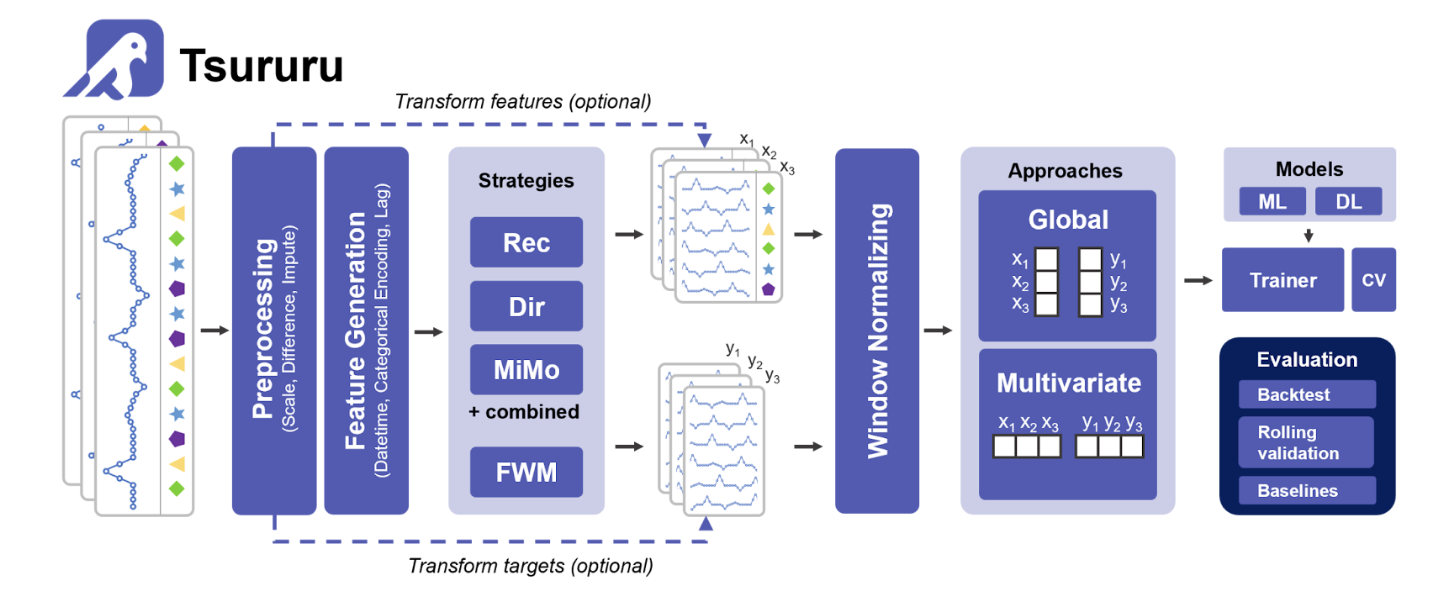

Tsururu — это открытая библиотека, объединяющая различные стратегии прогнозирования временных рядов с учетом их взаимного влияния.

__Стратегии прогнозирования нескольких временных рядов:__
- Global — одна модель для всех рядов, которые рассматриваются независимо.
- Multivariate — одна модель для всех рядов с учетом их взаимного влияния.

__Стратегии прогнозирования на несколько точек вперед:__
- Recursive — модель итеративно предсказывает следующий шаг и использует собственные предсказания для обновления входных данных.
- Direct —  для каждого шага горизонта прогнозирования обучается отдельная модель, что позволяет делать прогнозы независимо.
- MIMO — одна модель предсказывает сразу весь горизонт прогнозирования.
- FlatWideMIMO — одна модель предсказывает конкретную точку горизонта, при этом шаг прогнозирования передается как входной признак.
- Комбинированные стратегии — Recursive + MIMO, Direct + MIMO.

Сегодня не будем углубляться в детали и рассмотрим самый простой пример того, как можно получить интересующие нас прогнозы.

In [30]:
from tsururu.dataset import Pipeline, TSDataset
from tsururu.model_training.trainer import MLTrainer
from tsururu.model_training.validator import KFoldCrossValidator
from tsururu.models.boost import CatBoost
from tsururu.strategies import RecursiveStrategy

In [31]:
train_df = train_df.rename(columns={
    "unique_id": "id",
    "y": "value",
    "ds": "date",
})

Снова разделим данные на обучающую и тестовую выборки.

In [32]:
HORIZON = 36
HISTORY = 52

train_df = []
test_df = []
test_targets = []

for current_id in df["id"].unique():
    current_df = df[df["id"] == current_id]
    # |--------------------- TRAIN_DF -------------------------------------- TEST_DF ----------------|------ TEST_TARGETS ------|
    # |----------- from start to (-2 * horizon) -----------| from (-horizon - history) to (-horizon) | from (-horizon) to (end) |
    # NOTE: TRAIN_DF and TEST_DF are overlapping, but TEST_TARGETS is not
    train_df.append(current_df.iloc[:-HORIZON])
    test_df.append(current_df.iloc[-HORIZON - HISTORY : -HORIZON])
    test_targets.append(current_df.iloc[-HORIZON:])

train_df = pd.concat(train_df)
test_df = pd.concat(test_df)
test_targets = pd.concat(test_targets)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Test targets shape: {test_targets.shape}")

print(f"Number of series in train set: {train_df['id'].nunique()}")
print(f"Number of series in test set: {test_df['id'].nunique()}")
print(f"Number of series in test targets set: {test_targets['id'].nunique()}")

Train shape: (96104, 3)
Test shape: (19032, 3)
Test targets shape: (13176, 3)
Number of series in train set: 366
Number of series in test set: 366
Number of series in test targets set: 366


Обратите внимание, что тут никакой подвыборки нет! Время обучения и прогноза честное для анализа всех 366 рядов.

Будем использовать Recursive Global стратегию с базовой моделью CatBoost, которая в качестве признаков использует HISTORY лагов и признаки на основе дат. Также по умолчанию происходит скейлинг временного ряда.

In [33]:
# Нужно отметить, какие колонки за какие роли отвечают (какая колонка является таргетом, датой и идентификатором)
dataset_params = {
    "target": {"columns": ["value"]},
    "date": {"columns": ["date"]},
    "id": {"columns": ["id"]},
}

# Инициализируем внутренний класс, который отвечает за хранение данных и мета-информации
train_dataset = TSDataset(
    data=train_df,
    columns_params=dataset_params,
)
test_dataset = TSDataset(
    data=test_df,
    columns_params=dataset_params,
)

# В следующий раз подробнее разберем роль Pipeline, вкратце — это класс, который отвечает за трансформации временного ряда
# На всех этапах прогноза от препроцессинга и генерации признаков до Window_normalizing (нормализации на уровне наблюдений для ML моделей)
# multivariate=False означает, что используем global режим (в нашей задаче единственный возможный вариант, т. к. ряды не выровнены)
pipeline = Pipeline.easy_setup(
    dataset_params, {"target_lags": HISTORY, "date_lags": 1}, multivariate=False
)
# Trainer отвечает за обучение модели с использованием inner loop валидации
trainer = MLTrainer(model=CatBoost, validator=KFoldCrossValidator)
# Стратегия отвечает за то, как мы генерируем выборку для предсказания на несколько точек вперед (подробнее на лекции)
strategy = RecursiveStrategy(horizon=HORIZON, history=HISTORY, trainer=trainer, pipeline=pipeline)

fit_time, _ = strategy.fit(train_dataset)
forecast_time, current_pred = strategy.predict(test_dataset)

INFO:tsururu.dataset.dataset:freq: Month; period: 1.0
                It seems that the data is not regular. Please, check the data and the frequency info.                
                For multivariate regime it is critical to have regular data.
                For global regime each regular part of time series will be processed as separate time series.           
                
INFO:tsururu.dataset.dataset:freq: Month; period: 1.0
                It seems that the data is not regular. Please, check the data and the frequency info.                
                For multivariate regime it is critical to have regular data.
                For global regime each regular part of time series will be processed as separate time series.           
                
INFO3:tsururu.models.boost:0:	learn: 0.9741811	test: 0.9763316	best: 0.9763316 (0)	total: 75.3ms	remaining: 1m 15s
DEBUG:tsururu.models.boost:100:	learn: 0.5034061	test: 0.5062607	best: 0.5062607 (100)	total: 1.61s	remaining: 

In [34]:
analyze_predictions(train_df, test_targets, current_pred, last_points=50)

random 10 mae: 1520.4824864807078
